<b>Name:</b> Aishwarya Bhavsar<br>
<b>CSULBID:</b> 029371509<br>
CECS 551 Assignment 7


**Import Libraries And Download Dataset**

In [2]:
import os

import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


**Normalize The Data And Convert It RGB To GRAYSCALE Image For Fast Training**

In [3]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

In [4]:
x_train=np.dot(x_train[...,:3], [0.299, 0.587, 0.114])
x_test=np.dot(x_test[...,:3], [0.299, 0.587, 0.114])
#add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

**(a) Split the training dataset into sub training and validation sets randomly. Use 1/5 of training dataset as validation set. Use the ‘accuracy’ as metric. Please repeat 10 times of random split and aggregate (average) the accuracy**

**Split The Dataset Into Train And Valid.**

StratifiedKFold just shuffles and splits once, therefore the test sets do not overlap, while StratifiedShuffleSplit shuffles each time before splitting, and it splits n_splits times, the test sets can overlap.

In [5]:
s = StratifiedShuffleSplit(n_splits = 10, random_state=0, test_size=1/5)
train_index, valid_index = next(s.split(x_train, y_train))
x_valid, y_valid = x_train[valid_index], y_train[valid_index]
x_train, y_train = x_train[train_index], y_train[train_index]
print(x_train.shape, x_valid.shape,x_test.shape)

(40000, 32, 32, 1) (10000, 32, 32, 1) (10000, 32, 32, 1)


<b>(b) Model evaluation<br>
• Evaluate multiple combinations of activation function, optimizer, hyper-parameter,generalization (including data augmentation), and architecture.<br>
• Using sub training and validation datasets, find the best models.<br>
• Report 3 best models in terms of test accuracy.

<b>Conv2D:</b> Performs convolution.<br>
<b>filters:</b> Number of output channels.<br>
<b>kernel_size:</b> An integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window. <br>
Kernel_size should be 2*2 or 3*3 to extract better local feature.<br><br>
<b>Padding:</b> padding=”same” adds zero padding to the input, so that the output has the same width and height, padding=’valid’ performs convolution only in locations where kernel and the input fully overlap.<br><br>
If you train the network with a large batch-size (say 10 or more), use BatchNormalization layer. BatchNormalization normalize the activation of previous layer at each batch. i.e. applies a transformation that maintains the mean activation close to 0 and activation std close to 0.<br><br>
<b>Activation:</b> ELU units actually seem to learn faster than other units and they are able to learn models which are at least as good as ReLU-like networks.<br>
<b>Input_shape:</b> Shape of input. i.e. (32,32,1)<br>
<b>MaxPooling2D</b> — Performs 2D max pooling.<br>
<b>Flatten</b> — Flattens the input, does not affect the batch size.<br>
<b>Dense</b> — Fully-connected layer.<br>
<b>Dropout</b> — Applies dropout to inactive some neurons that causes over fitting.

<b>Define The Model</b>

In [6]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.BatchNormalization(input_shape = x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(64, (5,5), padding='same',activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape = x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(128, (5,5), padding='same',activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.BatchNormalization(input_shape = x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(256, (5,5), padding='same',activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation('elu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 32, 32, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                        

**Compile The Model**

In [7]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

<b>Fit The Model</b>

<b>Data Augmentation</b>

In [9]:
#Setting up a data augmentation configuration via ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,
fill_mode='nearest')

In [10]:

#Module with imagepreprocessing utilities
from keras.preprocessing import image

In [21]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)
 
    
batch_size=128
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, verbose=1)
history=model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=30,
    steps_per_epoch=int(np.ceil(x_train.shape[0] / batch_size)),
    validation_data=(x_valid, y_valid),callbacks=[early_stop]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/30
313/313 [==============================] - 700s 2s/step - loss: 2.5366 - accuracy: 0.0931 - val_loss: 4.6320 - val_accuracy: 0.0121
Epoch 2/30
313/313 [==============================] - 691s 2s/step - loss: 1.8694 - accuracy: 0.0929 - val_loss: 1.4009 - val_accuracy: 0.0664
Epoch 3/30
313/313 [==============================] - 694s 2s/step - loss: 1.5508 - accuracy: 0.0955 - val_loss: 1.4018 - val_accuracy: 0.0893
Epoch 4/30
313/313 [==============================] - 697s 2s/step - loss: 1.3549 - accuracy: 0.0959 - val_loss: 1.0583 - val_accuracy: 0.0878
Epoch 5/30
313/313 [==============================] - 696s 2s/step - loss: 1.2440 - accuracy: 0.0988 - val_loss: 1.3826 - val_accuracy: 0.1182
Epoch 6/30
313/313 [==============================] - 691s 2s/step - loss: 1.1762 - accuracy: 0.0995 - val_loss: 0.9503 - val_accuracy: 0.1054
Epoch 7/30
313/313 [==============================] - 693s 2s/step - loss: 1.1271 - accuracy: 0.1020 - val_loss: 0.9837 - val_accuracy: 0.0988

<Figure size 288x216 with 0 Axes>

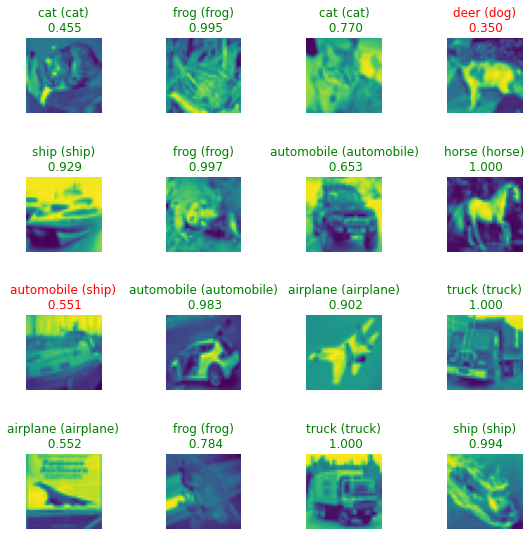

In [25]:
LABEL_NAMES=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

#cpu_model = model.sync_to_cpu()

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions, true_labels):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  fig = pyplot.figure(figsize=(4,3))
  # axes = fig.add_subplot(nc, 4)
  f, axes = pyplot.subplots(nc, 4)
  f.tight_layout()
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    pred_label = np.argmax(predictions[i])
    axes[x, y].set_title("{} ({})\n {:.3f}".format(
      LABEL_NAMES[pred_label], 
      LABEL_NAMES[true_labels[i][0]],
      confidence
    ), color=("green" if true_labels[i] == pred_label else "red"))
  pyplot.gcf().set_size_inches(8, 8)  

plot_predictions(
    np.squeeze(x_test[:16]), 
    model.predict(x_test[:16]),
    y_test[:16]
)

<b>Validation Accuracy</b><br>
<b>9.79%</b>

In [27]:
%%time
# Evaluate the model on valid set
score = model.evaluate(x_valid, y_valid, verbose=0)

# Print test accuracy
print('\n', 'Valid accuracy:', score[1])


 Valid accuracy: 0.09790000319480896
CPU times: user 1min 15s, sys: 480 ms, total: 1min 15s
Wall time: 40.7 s


<b>Test Accuracy</b><br>
<b>10.28%</b>

In [29]:
%%time
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.10289999842643738
CPU times: user 1min 15s, sys: 469 ms, total: 1min 15s
Wall time: 39.5 s
